# STITCHES Full tutorial

The purpose of this tutorial is to demonstrate how `stitches` can be used as an emulator. While `stitches` can
 emulate a number of CMIP6 models this example will focus on emulating CanESM5 SSP245 results.

To use `stitches`, there are a number of user decisions that have to be made,
perhaps the two most important being the target and archive data.

* target data: the temperature time series that is to be emulated
* archive data: the values to be used in the matching process, the archive data should only include entries
for a specific ESM.

A diagram illustrating the `stitches` process is included for reference:

![stitches workflow](STITCHES-diagram.jpg)

- `stitches` defaults to $X=9$ year windows.

### Getting Started

Start by loading the stitches package (see [installation instructions](https://github.com/jgcri/stitches)
if `stitches` must be installed).

In [1]:
import stitches as stitches

Load the additional python libraries that will be used in this example.

In [2]:
import pandas as pd
import pkg_resources
import xarray as xr
import numpy as np

# For help with plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6



# Example: Emulate global mean air temperature

We will begin with an example focused on emulating global mean air
temperature before moving on to an example producing gridded data for
multiple variables.

The global mean air temperature (GSAT) is the key variable upon which
`stitches` operates to construct new realizations and is easy to visualize.

### Example Set Up

**Decide on the target data.**

- Start by selecting a specific ESM for `stitches` to emulate, a specific ESM must be selected for emulation and
a specific scenario must be targeted.
- This can be either a novel scenario defined as a time series of global mean air
temperature, or it can be an existing CMIP6 scenario to enrich the ensemble for.
- Since the objective of this example is to illustrate
how `stitches` can be used in emulation, let's use SSP245 results from CanESM5, that
way we can compare the final stitched products with the actual model results.
- Since this ESM-scenario combination exists within the `stitches` package data,
we load that file and subset to arrive at our target.
- This package data includes all ESMs-Scenarios-ensemble members available.
In this file, model monthly tas output has been processed to the GSAT
anomaly windows that `stitches` operates on.


In [3]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
path = pkg_resources.resource_filename('stitches', 'data/matching_archive.csv')
data = pd.read_csv(path)

# subset to the target
target_data = data[data["model"] == "CanESM5"].copy()
target_data = target_data[target_data["experiment"] == 'ssp245']
target_data = target_data[target_data["ensemble"].isin(['r1i1p1f1'])]
target_data = target_data.reset_index(drop=True)
print(target_data.head())

   ensemble variable    model experiment  start_yr  end_yr  year        fx  \
0  r1i1p1f1      tas  CanESM5     ssp245      1850    1858  1854 -1.289870   
1  r1i1p1f1      tas  CanESM5     ssp245      1859    1867  1863 -1.268776   
2  r1i1p1f1      tas  CanESM5     ssp245      1868    1876  1872 -1.215083   
3  r1i1p1f1      tas  CanESM5     ssp245      1877    1885  1881 -1.195105   
4  r1i1p1f1      tas  CanESM5     ssp245      1886    1894  1890 -1.250430   

         dx  
0 -0.003368  
1  0.009320  
2  0.004758  
3 -0.014627  
4  0.014695  


- In this demonstration, we will specifically be targeting ensemble member 1
of the CanESM5 SSP245 simulations. The entire SSP245 ensemble may be
jointly targeted by omitting the line
`target_data = target_data[target_data["ensemble"].isin(['r1i1p1f1'])]`


**Decide on the archive data.**
- In this example, we will pretend SSP245 is a novel scenario rather than one
run by the ESM and available.
- emulating a GSAT time series for a novel scenario (e.g. from Hector) is one
of the most challenging tasks for `stitches`.
- This also has the benefit of comparison data being available for comparison.

In [4]:
archive_data = data[data["model"] == "CanESM5"]
archive_data = archive_data[archive_data["experiment"].isin([
    'ssp126',  'ssp370', 'ssp585'])]
print(archive_data.head())

       ensemble variable    model experiment  start_yr  end_yr  year  \
6996  r10i1p1f1      tas  CanESM5     ssp126      1850    1858  1854   
6997  r10i1p1f1      tas  CanESM5     ssp126      1859    1867  1863   
6998  r10i1p1f1      tas  CanESM5     ssp126      1868    1876  1872   
6999  r10i1p1f1      tas  CanESM5     ssp126      1877    1885  1881   
7000  r10i1p1f1      tas  CanESM5     ssp126      1886    1894  1890   

            fx        dx  
6996 -1.360399  0.016472  
6997 -1.297474 -0.001508  
6998 -1.200856  0.010901  
6999 -1.218503 -0.016847  
7000 -1.285527  0.006000  


Use the target_data and archive_data to make the recipes using the function
`make_recipe`.

- We ask for 4 new realizations to be constructed, and we specify that
the matching be limited to a `tol`  ($Z$ in the diagram) value of 0.06degC.
- `tol` is the parameter that effectively controls both the maximum number
of generated time series that may be constructed, and the quality of the time
series.
- For large values of `tol`, the matches constructed may be no good.
Currently, the cutoff values of `tol` for each ESM are determined by post-hoc
calculation, as described in the ESD paper.

In [5]:
my_recipes = stitches.make_recipe(target_data, archive_data,
                                  tol = 0.06, N_matches = 4)

print(my_recipes.head())

You have requested more recipes than possible for at least one target trajectories, returning what can


/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:460: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recipe_collection = recipe_collection.append(recipes_col_by_target)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:517: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  historical_period = ser.append(constant_info).to_frame().transpose()
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:534: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_period = ser.append(constant_info).to_frame().transpose()
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:517: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pand

  target_start_yr target_end_yr archive_experiment archive_variable  \
0            1850          1858         historical              tas   
1            1859          1867         historical              tas   
2            1868          1876         historical              tas   
3            1877          1885         historical              tas   
4            1886          1894         historical              tas   

  archive_model archive_ensemble       stitching_id archive_start_yr  \
0       CanESM5         r1i1p1f1  ssp245~r1i1p1f1~1             1850   
1       CanESM5        r24i1p1f1  ssp245~r1i1p1f1~1             1913   
2       CanESM5        r22i1p1f1  ssp245~r1i1p1f1~1             1922   
3       CanESM5         r3i1p1f1  ssp245~r1i1p1f1~1             1850   
4       CanESM5         r9i1p1f1  ssp245~r1i1p1f1~1             1868   

  archive_end_yr                                           tas_file  
0           1858  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...  


- note the message that the requested number of  matches (4)  is more than
this archive + `tol` combination can support. Results for as many realizations
as possible are returned.


Now use the recipe to get the global mean air temperature using `gmat_stitching`.
The data frame returned by `gmat_stitching` will contain the stitched product.

In [6]:
stitched_global_temp = stitches.gmat_stitching(my_recipes)
print(stitched_global_temp.head())


/Users/snyd535/Documents/GitHub/stitches/stitches/fx_stitch.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data["experiment"] = "historical"
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_stitch.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data["experiment"] = "historical"


   year     value variable       stitching_id
0  1850 -1.133884      tas  ssp245~r1i1p1f1~1
1  1851 -1.389375      tas  ssp245~r1i1p1f1~1
2  1852 -1.318175      tas  ssp245~r1i1p1f1~1
3  1853 -1.163771      tas  ssp245~r1i1p1f1~1
4  1854 -1.302066      tas  ssp245~r1i1p1f1~1


/Users/snyd535/Documents/GitHub/stitches/stitches/fx_stitch.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_data["experiment"] = "historical"


### Visualize Results

Plot the stitched outputs.

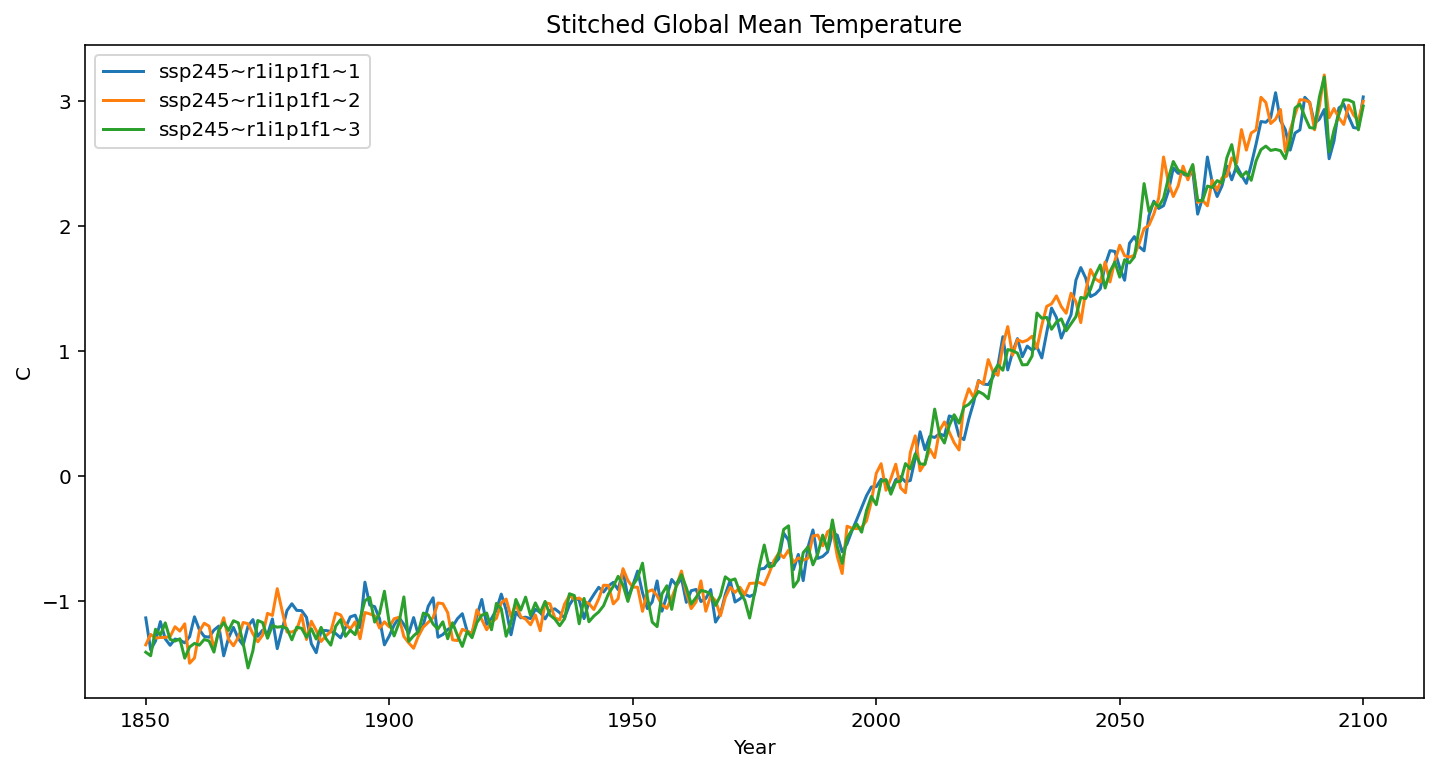

In [7]:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, label = name)
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()



Now compare the stitched products with the actual comparison data.
- The black curve is realization 1 - the actual targeted realization.
- The gray curves are the other archived realizations of SSP245 for CanESM5
to illustrate that the generated ensemble members do not systematically
depart from the actual ensemble behavior.
- GSAT data is included as package data in `stitches` for convenience.

In [8]:
# Load the comparison GSAT data
data_path = pkg_resources.resource_filename('stitches', 'data/tas-data/CanESM5_tas.csv')
comp_data = pd.read_csv(data_path)
comp_data = comp_data[comp_data["experiment"] == "ssp245"]
print(comp_data.head())

      variable experiment   ensemble    model  year     value  \
13354      tas     ssp245  r10i1p1f1  CanESM5  1850 -1.492062   
13355      tas     ssp245  r10i1p1f1  CanESM5  1851 -1.431112   
13356      tas     ssp245  r10i1p1f1  CanESM5  1852 -1.384312   
13357      tas     ssp245  r10i1p1f1  CanESM5  1853 -1.277318   
13358      tas     ssp245  r10i1p1f1  CanESM5  1854 -1.479817   

                                                  zstore  
13354  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/his...  
13355  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/his...  
13356  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/his...  
13357  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/his...  
13358  gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/his...  


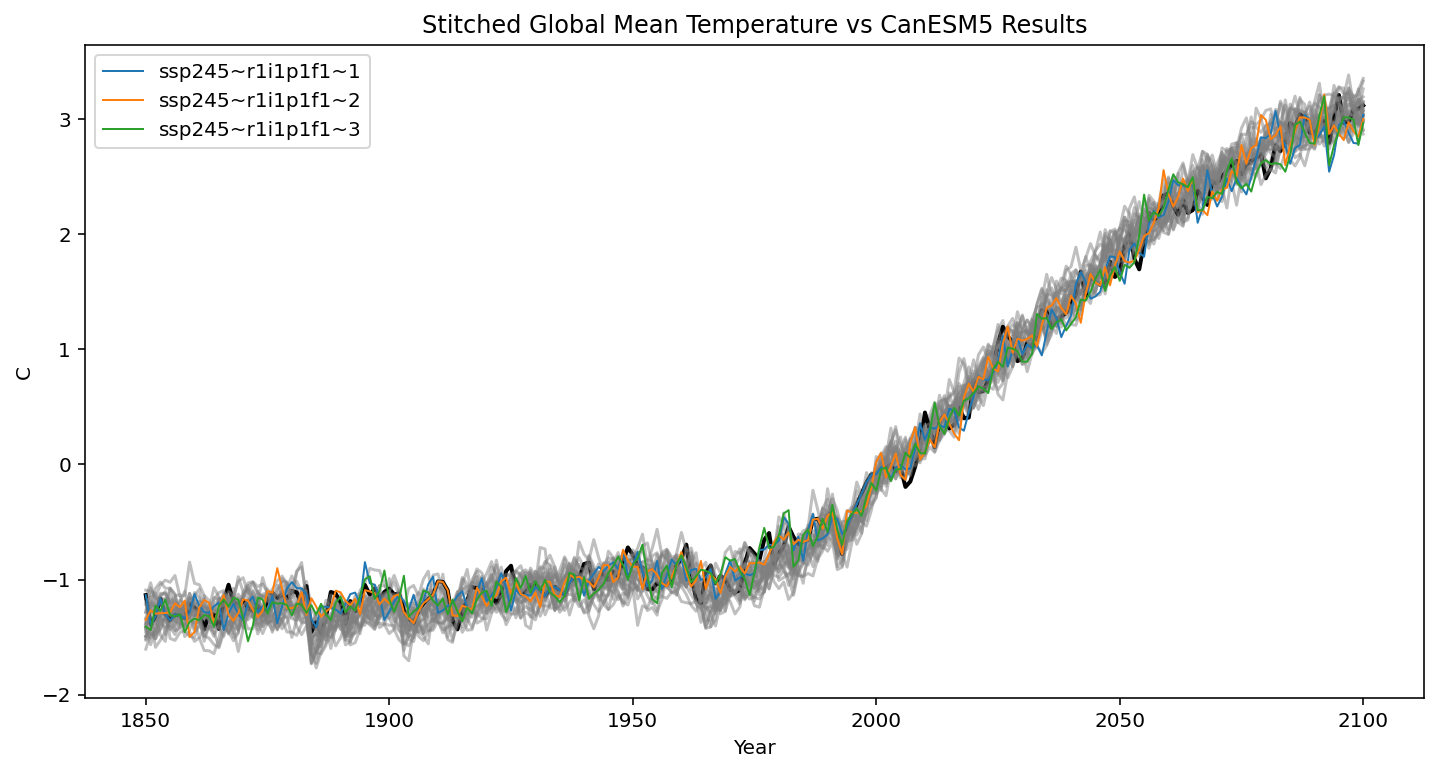

In [9]:
# Plot results
# full ensemble of actual ESM runs:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
    else:
        plt.plot(group.year, group.value, color = "0.5", alpha=0.5)

# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()



# Example: stitching gridded products for multiple variables.

With the basis of matching illustrated in the above example, we highlight
especially the structure of the 'recipes' `stitches` creates:

In [10]:
print(my_recipes.iloc[0,])

target_start_yr                                                    1850
target_end_yr                                                      1858
archive_experiment                                           historical
archive_variable                                                    tas
archive_model                                                   CanESM5
archive_ensemble                                               r1i1p1f1
stitching_id                                          ssp245~r1i1p1f1~1
archive_start_yr                                                   1850
archive_end_yr                                                     1858
tas_file              gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...
Name: 0, dtype: object


The `tas_file` entry points to the specific CMIP6 netcdf file on pangeo that
must be pulled for these years to create gridded data.

With arguments, the function `stitches.make_recipe()` can return recipes
with columns for additional specific variables of interest.

## Multiple variables
- As before, target and archive data must be specified, for a single ESM.


### setup data

In [11]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
path = pkg_resources.resource_filename('stitches', 'data/matching_archive.csv')
data = pd.read_csv(path)

# subset for the target
target_data = data[data["model"] == "CanESM5"].copy()
target_data = target_data[target_data["experiment"] == 'ssp245']
target_data = target_data[target_data["ensemble"].isin(['r1i1p1f1'])]
target_data = target_data.reset_index(drop=True)
print(target_data.head())

# subset for the archive
archive_data = data[data["model"] == "CanESM5"]
archive_data = archive_data[archive_data["experiment"].isin([
    'ssp126',  'ssp370', 'ssp585'])]
print(archive_data.head())

   ensemble variable    model experiment  start_yr  end_yr  year        fx  \
0  r1i1p1f1      tas  CanESM5     ssp245      1850    1858  1854 -1.289870   
1  r1i1p1f1      tas  CanESM5     ssp245      1859    1867  1863 -1.268776   
2  r1i1p1f1      tas  CanESM5     ssp245      1868    1876  1872 -1.215083   
3  r1i1p1f1      tas  CanESM5     ssp245      1877    1885  1881 -1.195105   
4  r1i1p1f1      tas  CanESM5     ssp245      1886    1894  1890 -1.250430   

         dx  
0 -0.003368  
1  0.009320  
2  0.004758  
3 -0.014627  
4  0.014695  
       ensemble variable    model experiment  start_yr  end_yr  year  \
6996  r10i1p1f1      tas  CanESM5     ssp126      1850    1858  1854   
6997  r10i1p1f1      tas  CanESM5     ssp126      1859    1867  1863   
6998  r10i1p1f1      tas  CanESM5     ssp126      1868    1876  1872   
6999  r10i1p1f1      tas  CanESM5     ssp126      1877    1885  1881   
7000  r10i1p1f1      tas  CanESM5     ssp126      1886    1894  1890   

            fx

### match and stitch

- by using the `non_tas_variables` argument to `stitches.make_recipe()`,
the recipes now include columns `tas_file` and `pr_file` pointing  to the
specific CMIP6 netcdf files for `tas` and `pr` monthly data on pangeo that
must be pulled for these years to create gridded data.
- variables other than surface air temperature and precipitation may be
considered of course
- we will only generate a recipe for one new realization for expediency, but
`N_matches` may be increased with no changes to the stitching calls below.

In [12]:
my_recipes = stitches.make_recipe(target_data, archive_data,
                                  tol = 0.06,
                                  non_tas_variables=['pr'],
                                  N_matches = 1)
print(my_recipes.head())

/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:460: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recipe_collection = recipe_collection.append(recipes_col_by_target)
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:517: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  historical_period = ser.append(constant_info).to_frame().transpose()
/Users/snyd535/Documents/GitHub/stitches/stitches/fx_recepie.py:534: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_period = ser.append(constant_info).to_frame().transpose()


  target_start_yr target_end_yr archive_experiment archive_variable  \
0            1850          1858         historical              tas   
1            1859          1867         historical              tas   
2            1868          1876         historical              tas   
3            1877          1885         historical              tas   
4            1886          1894         historical              tas   

  archive_model archive_ensemble       stitching_id archive_start_yr  \
0       CanESM5        r24i1p1f1  ssp245~r1i1p1f1~1             1895   
1       CanESM5         r8i1p1f1  ssp245~r1i1p1f1~1             1850   
2       CanESM5        r24i1p1f1  ssp245~r1i1p1f1~1             1922   
3       CanESM5         r7i1p1f1  ssp245~r1i1p1f1~1             1868   
4       CanESM5        r23i1p1f1  ssp245~r1i1p1f1~1             1913   

  archive_end_yr                                           tas_file  \
0           1903  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...  

To stitch new realizations of the gridded data as netcdfs, the `stitches`
function `gridded_stitching` is used and the results are saved in a user-
specified directory. In this example, it is the same directory this notebook
sits in.

These netcdf files may then be read in and examined with `xarray` functions.

In [13]:
stitches.gridded_stitching(out_dir='.', rp = my_recipes)

['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~1']


['./stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc',
 './stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc']

### load in generated and target data for comparison

In [14]:
# load the stitched (generated) netcdf files
gen_tas = xr.open_dataset('stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc')
gen_tas

<xarray.Dataset>
Dimensions:  (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2100-12-31
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    tas      (time, lat, lon) float32 ...

In [15]:
# load the stitched netcdf files
gen_pr = xr.open_dataset('stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc')
gen_pr

<xarray.Dataset>
Dimensions:  (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2100-12-31
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr       (time, lat, lon) float32 ...

In [16]:
# pull the actual CanESM5 data from pangeo for comparison:
# pangeo table of ESMs for reference
pangeo_path = pkg_resources.resource_filename('stitches', 'data/pangeo_table.csv')
pangeo_data = pd.read_csv(pangeo_path)
pangeo_data = pangeo_data[((
                               (pangeo_data['variable'].isin(['tas', 'pr'])))  )
                          & ((pangeo_data['domain'].str.contains('mon')) ) &
                           ((pangeo_data['experiment'].isin(['ssp245']))) &
                          (pangeo_data['ensemble'].isin(['r1i1p1f1']))&
                          (pangeo_data['model'].isin(['CanESM5']))].copy()
pangeo_data

,model,experiment,ensemble,variable,zstore,domain
21843,CanESM5,ssp245,r1i1p1f1,pr,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,Amon
21910,CanESM5,ssp245,r1i1p1f1,tas,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,Amon


In [17]:
# load the target tas netcdf files
tas_address = pangeo_data[pangeo_data['variable']== 'tas'].zstore.copy()
tar_tas = stitches.fx_pangeo.fetch_nc(tas_address.values[0])
tar_tas

<xarray.Dataset>
Dimensions:    (lat: 64, bnds: 2, lon: 128, time: 1032)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
    CCCma_parent_runid:          rc3.1-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s4501
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    variable_id:                 tas
    variant_label:               r1i1p1f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/cb64f06c-d829-4b02-8229-5f66bbe...
    version_id:                  v20190429

In [18]:
# load the target pr netcdf files
pr_address = pangeo_data[pangeo_data['variable']== 'pr'].zstore.copy()
tar_pr = stitches.fx_pangeo.fetch_nc(pr_address.values[0])
tar_pr


<xarray.Dataset>
Dimensions:    (lat: 64, bnds: 2, lon: 128, time: 1032)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 64, 128), meta=np.ndarray>
Attributes: (12/56)
    CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
    CCCma_parent_runid:          rc3.1-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s4501
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    ...                          ...
    variable_id:                 pr
    variant_label:               r1i1p1f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/01974ab8-7640-4389-8002-a96eb2a...
    version_id:                  v20190429

### visualize
select a grid cell and plot the generated and target tas, pr data for first-cut
comparison

/var/folders/3t/b48tg9616bj3_bhcjwwll8cmg9cj39/T/ipykernel_81885/1495344644.py:28: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plt.plot(cp_tas_tar.indexes['time'].to_datetimeindex(),


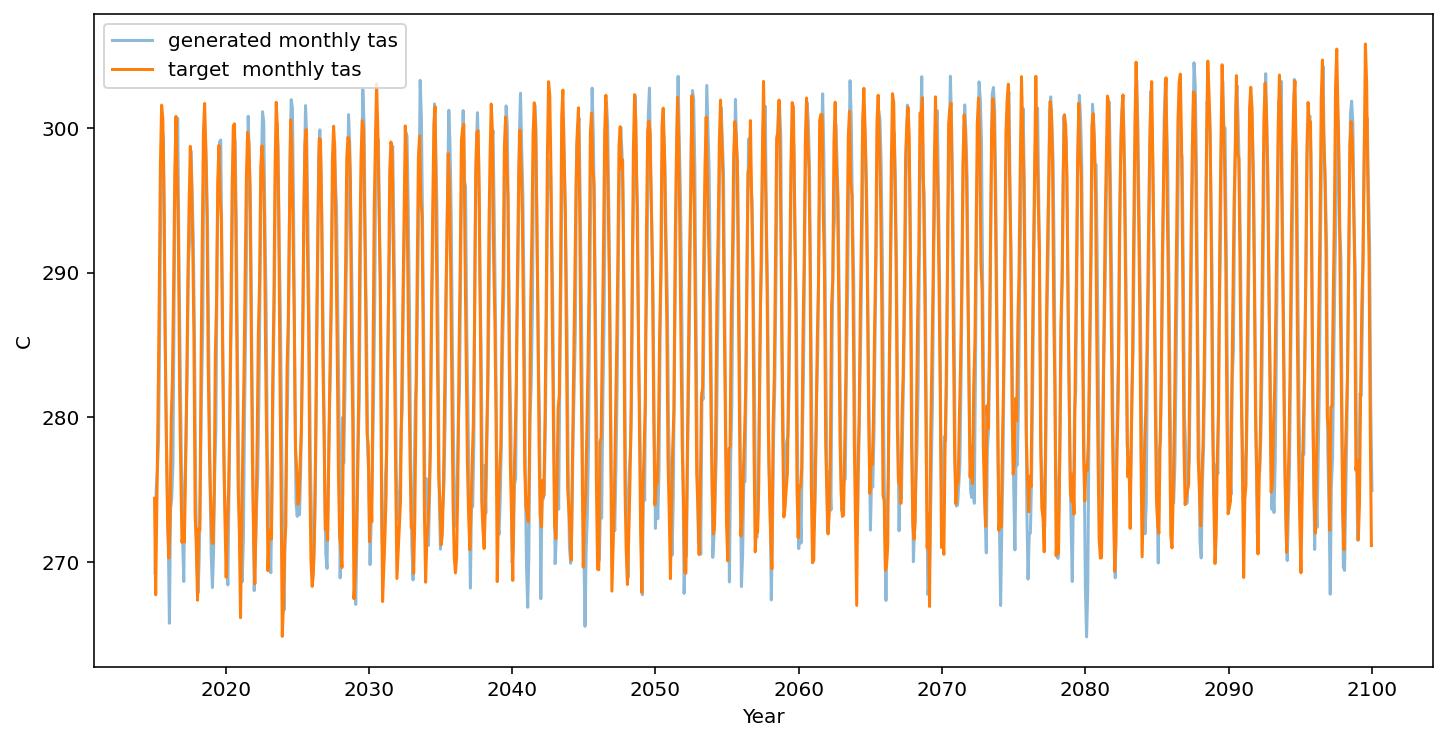

/var/folders/3t/b48tg9616bj3_bhcjwwll8cmg9cj39/T/ipykernel_81885/1495344644.py:41: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  plt.plot(cp_pr_tar.indexes['time'].to_datetimeindex(),


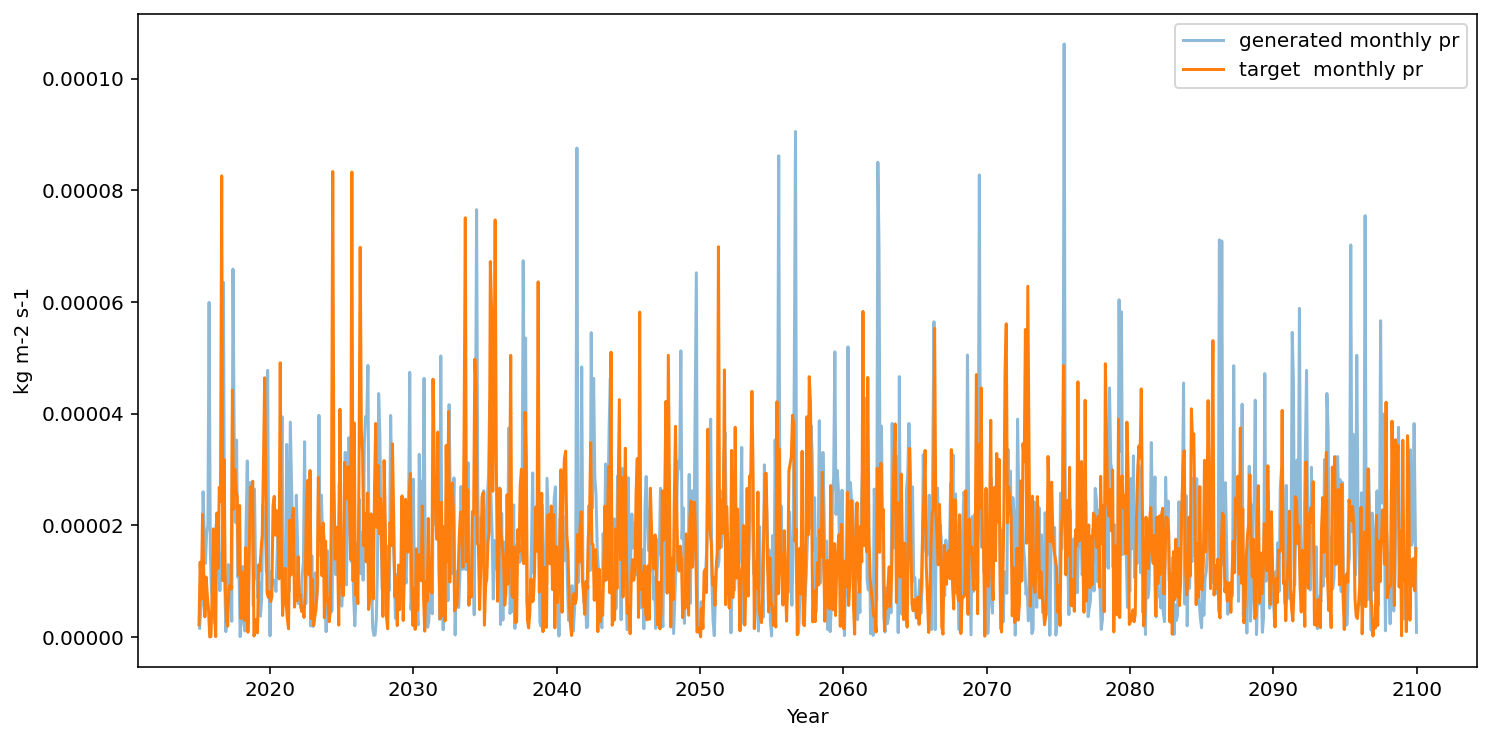

In [19]:
# lon and lat values for a grid cell near College Park, MD, home of JGCRI:
cp_lat = 38.9897
cp_lon = 180 + 76.9378 # this is probably not actually right 

# lat and lon coordinates closest
abslat = np.abs(gen_tas.lat - cp_lat)
abslon = np.abs(gen_tas.lon-cp_lon)
c = np.maximum(abslon, abslat)
([lon_loc], [lat_loc]) = np.where(c == np.min(c))
lon_grid = gen_tas.lon[lon_loc]
lat_grid = gen_tas.lat[lat_loc]

cp_tas_gen = gen_tas.sel(lon = lon_grid, lat=lat_grid,
                         time = slice('2015-01-01', '2099-12-31')).copy()
cp_tas_tar = tar_tas.sel(lon = lon_grid, lat=lat_grid,
                         time = slice('2015-01-01', '2099-12-31')).copy()

cp_pr_gen = gen_pr.sel(lon = lon_grid, lat=lat_grid,
                       time = slice('2015-01-01', '2099-12-31')).copy()
cp_pr_tar = tar_pr.sel(lon = lon_grid, lat=lat_grid,
                       time = slice('2015-01-01', '2099-12-31')).copy()

# tas
plt.plot(cp_tas_gen.time,
         cp_tas_gen.tas,
         alpha=0.5,
         label = 'generated monthly tas')
plt.plot(cp_tas_tar.indexes['time'].to_datetimeindex(),
         cp_tas_tar.tas,
         label = 'target  monthly tas')
plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.show()

# pr
plt.plot(cp_pr_gen.time,
         cp_pr_gen.pr,
          alpha=0.5,
         label = 'generated monthly pr')
plt.plot(cp_pr_tar.indexes['time'].to_datetimeindex(),
         cp_pr_tar.pr,
         label = 'target  monthly pr')
plt.legend()
plt.xlabel("Year")
plt.ylabel("kg m-2 s-1")
plt.show()

Visual validation of the complex spatial, temporal, and cross-variable
relationships present in ESM outputs is not possible. We extensively validate
that the method reproduces ESM internal variability in the ESD paper, but this
visual plotting at least suggests that nothing is obviously wrong.

In other words, it's not inconceivable from these plots that the orange time
series were sampled from the same underlying multivariate distribution that
generated the blue time series.